In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as random
key = random.key(0)
import argparse
import sys
import os
sys.path.append('..')
import optimistix as optx
from functools import partial
from traditional_solvers import Dx, Dxx, implicit_midpoint, gauss_legendre_4, gauss_legendre_6

###############INITIAL CONDITION####################

def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, η=6., P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=1.5, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    u0 = (-6./-η)*2 * c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += (-6./-η)*2 * c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return u0

#################PARAMETERS####################

η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 252 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 378 # N+1 time points 

t0 = 0.0 # initial time
t_final = 3.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ, "dx" : dx}
SPATIAL_ORDER = 6

#############EQUATION####################
def f(t, u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    return -Dx(η/2*u**2 + γ**2 * Dxx(u, dx, SPATIAL_ORDER), dx, SPATIAL_ORDER)

#############HAMILTONIANS################
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = -η/6*u**3 + 0.5*γ**2*Dx(u, dx)**2
    return dx*jnp.sum(integrand)


#############SOLVING####################

#parser = argparse.ArgumentParser(description="Generate kdv data")
#parser.add_argument("--running_on", type=str, choices=["local", "idun"], default="local", help="Specify where the code is running")
running_on = "local"

if running_on=="local":
    PATH = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
elif running_on=="idun":
    PATH = "/cluster/work/eirikaf/data/"
else:
    raise ValueError("running_on must be either 'local' or 'idun'")

NUM_SAMPLES_PER_LOOP = 1 # Number of samples to generate per loop
NUM_LOOPS = 1 # Number of loops
NUM_SAMPLES = NUM_SAMPLES_PER_LOOP*NUM_LOOPS # Total number

atol, rtol = 1e-12, 1e-12
data = jnp.empty((NUM_SAMPLES, N+1, M))

key = random.key(0)
for i in range(NUM_LOOPS):
    key, subkey = random.split(key)
    keys = random.split(subkey, NUM_SAMPLES_PER_LOOP)

    a = jax.vmap(initial_condition_kdv, (None, 0))(x, keys)

    data = data.at[i*NUM_SAMPLES_PER_LOOP:(i+1)*NUM_SAMPLES_PER_LOOP, ...].set(jax.vmap(gauss_legendre_6, (None, 0, None, None, None, None, None))(f, a, dt, t, args, rtol, atol))

# Append the values at x=0 to the end of the array to account for periodicity
data = jnp.concatenate((data, (data[:,:,0]).reshape(NUM_SAMPLES, N+1, 1)), axis=2)
x = jnp.concatenate((x, jnp.array([P])))

In [3]:
import matplotlib.pyplot as plt

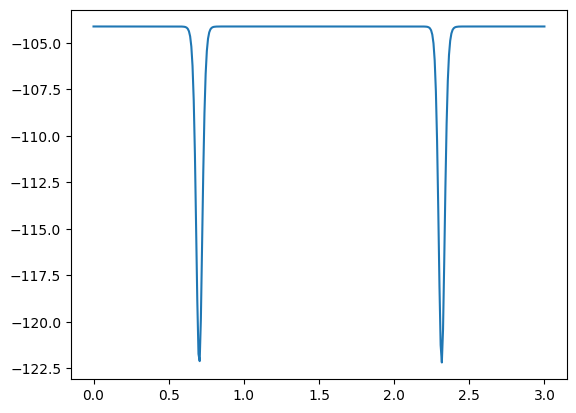

In [5]:
Hs2 = jax.vmap(H_energy, (0, None))(data[0], args)

plt.plot(t, Hs2)

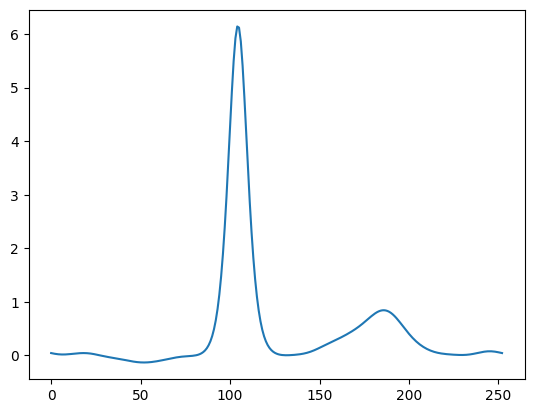

In [6]:
plt.figure()
plt.plot(data[0,-1])
plt.show()

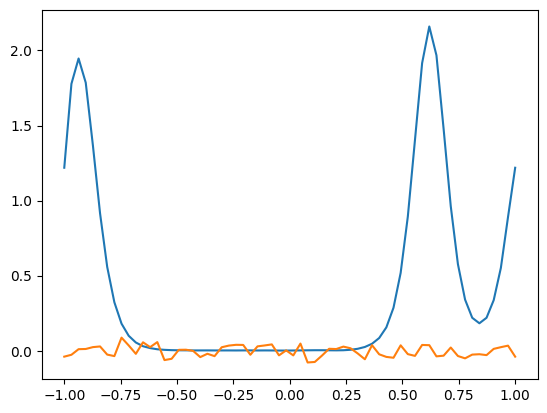

In [18]:
import matplotlib.pyplot as plt

plt.plot(x_train_s, data['data'][0,-1,::4])
plt.plot(x_train_s, u_train_s[0,-1,:])

In [1]:
import sys
import os
sys.path.append('..')

import jax
import equinox as eqx
import jax.numpy as jnp
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard
from optax.contrib import reduce_on_plateau

class LpLoss(object):
    def __init__(self, p=2):
        super(LpLoss, self).__init__()
        self.p = p

    def __call__(self, u_pred, u):
        num_examples = u_pred.shape[0]
        diff_norms = jnp.linalg.norm(u.reshape(num_examples,-1) - u_pred.reshape(num_examples,-1), self.p, 1)
        u_norms = jnp.linalg.norm(u.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/u_norms)

problem = "advection"
network = "modified_deeponet"
running_on = "local"

if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/"
    optuna_path = ""
elif running_on == "idun":
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/"
    optuna_path = "phlearn-summer24/eirik_prosjektoppgave/"
else:
    raise ValueError("Invalid running_on")

if problem == "advection":
    data = jnp.load(data_path + "advection.npz")
elif problem == "kdv":
    data = jnp.load(data_path + "kdv.npz")
else:
    raise ValueError("Invalid problem")

x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

a_test_n = a_normalizer.encode(a_test)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Set x and t as class attributes, since they are constant throughout the training
Trainer.x = x_n
Trainer.t = t_n

if network == "deeponet":
    from networks.deeponet import *
    from networks.deeponet import DeepONet as Network
    kwargs = {"number_of_sensors" : NUMBER_OF_SENSORS, "period" : (x_n[-1]-x_n[0]).item()}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "modified_deeponet":
    from networks.modified_deeponet import *
    from networks.modified_deeponet import ModifiedDeepONet as Network
    kwargs = {"number_of_sensors" : NUMBER_OF_SENSORS, "period" : (x_n[-1]-x_n[0]).item()}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "fno1d":
    from networks.fno1d import FNO1d as Network
    from networks.fno1d import *
    kwargs = {}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "fno2d":
    from networks.fno2d import FNO2d as Network
    from networks.fno2d import *
    kwargs = {}
    Trainer.compute_loss = staticmethod(compute_loss)
else:
    raise ValueError("Invalid network")

def compute_loss_mse(model, a, u, key, num_query_points=100):
    """Computes the loss of the model.
    Returns the MSE loss, averaged over the batch. The loss is computed by randomly selecting query points from the input data and evaluating the model at those points.

    Args:
        model (eqx.Module): The model to evaluate.
        a (batch, number_of_sensors): The input data.
        u (batch, num_query_points): The ground truth data at the query points.

    Returns:
        loss (scalar): The loss of the model for the given batch.
    """
    batch_size, Np1, Mp1 = u.shape
            
    # Select random query indices
    t_key, x_key = random.split(key, 2)
    t_idx = random.randint(t_key, (batch_size, num_query_points), 0, Np1)
    x_idx = random.randint(x_key, (batch_size, num_query_points), 0, Mp1)

    # Select the ground truth data at the query points
    # Has shape (batch_size, num_query_points)
    u_at_query_points = u[jnp.arange(batch_size)[:, None], t_idx, x_idx]
    
    # For each input function, compute the prediction of the model at the query points. (inner vmap)
    # Do this for each sample in the batch. (outer vmap)
    # Has shape (batch_size, num_query_points)   
    u_pred = vmap(vmap(model, (None, 0, 0)))(a, Trainer.x[x_idx], Trainer.t[t_idx])
    
    loss = jnp.mean(jnp.square(u_pred - u_at_query_points))
    return loss

def compute_loss_l2(model, a, u, key, num_query_points=100):
    """Computes the loss of the model.
    Returns the MSE loss, averaged over the batch. The loss is computed by randomly selecting query points from the input data and evaluating the model at those points.

    Args:
        model (eqx.Module): The model to evaluate.
        a (batch, number_of_sensors): The input data.
        u (batch, num_query_points): The ground truth data at the query points.

    Returns:
        loss (scalar): The loss of the model for the given batch.
    """
    batch_size, Np1, Mp1 = u.shape
            
    # Select random query indices
    t_key, x_key = random.split(key, 2)
    t_idx = random.randint(t_key, (batch_size, num_query_points), 0, Np1)
    x_idx = random.randint(x_key, (batch_size, num_query_points), 0, Mp1)

    # Select the ground truth data at the query points
    # Has shape (batch_size, num_query_points)
    u_at_query_points = u[jnp.arange(batch_size)[:, None], t_idx, x_idx]
    
    # For each input function, compute the prediction of the model at the query points. (inner vmap)
    # Do this for each sample in the batch. (outer vmap)
    # Has shape (batch_size, num_query_points)   
    u_pred = vmap(vmap(model, (None, 0, 0)))(a, Trainer.x[x_idx], Trainer.t[t_idx])
    
    l2_loss = LpLoss()
    loss = l2_loss(u_pred, u_at_query_points)
    return loss

# Create mesh for sharding (autoparallelism)
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1))
sharding_u = jshard.PositionalSharding(devices).reshape(num_devices, 1, 1)
sharding_a = jshard.PositionalSharding(devices)
replicated = sharding_a.replicate()

# Set sharding and replicated as class attributes, since they are constant throughout the training
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated

# Dataloaders

study = optuna.create_study(
    study_name=network + "_" + problem,
    storage=f"sqlite:///"+ optuna_path + "optuna/optuna.db",
    load_if_exists=True,
)

hparams = Hparams(**study.best_params, **kwargs)

# OPTIMIZER 
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate
RTOL = 1e-4  # Relative tolerance for measuring the new optimum
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value

opt = optax.adam(hparams.learning_rate)

l2_loss = LpLoss()

## MSE loss with standardized data

In [20]:
import importlib
importlib.reload(trainer)
from utils.trainer import Trainer
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated
Trainer.x = x_n
Trainer.t = t_n
Trainer.compute_loss = staticmethod(compute_loss_mse)
model = Network(hparams)
model = eqx.filter_shard(model, replicated)
opt_state = opt.init(eqx.filter([model], eqx.is_array))
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
trainer_mse_loss_standardized = Trainer(model, opt, opt_state, train_loader, val_loader)
trainer_mse_loss_standardized(100)

Output()

In [22]:
u_pred_n = vmap(vmap(vmap(trainer_mse_loss_standardized.model, (None, 0, None)), (None, None, 0)),(0, None, None))(a_test_n, Trainer.x, Trainer.t)
u_pred = u_normalizer.decode(u_pred_n)
mse_loss_l2_err_n = l2_loss(u_pred, u_test)
mse_loss_mse_err_n = jnp.mean(jnp.square(u_pred-u_test))

# L2 with standardized data

In [23]:
import importlib
importlib.reload(trainer)
from utils.trainer import Trainer
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated
Trainer.x = x_n
Trainer.t = t_n
Trainer.compute_loss = staticmethod(compute_loss_l2)
model = Network(hparams)
model = eqx.filter_shard(model, replicated)
opt_state = opt.init(eqx.filter([model], eqx.is_array))
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
trainer_l2_loss_standardized = Trainer(model, opt, opt_state, train_loader, val_loader)
trainer_l2_loss_standardized(100)

Output()

In [24]:
u_pred_n = vmap(vmap(vmap(trainer_l2_loss_standardized.model, (None, 0, None)), (None, None, 0)),(0, None, None))(a_test_n, Trainer.x, Trainer.t)
u_pred = u_normalizer.decode(u_pred_n)
l2_loss_l2_err_n = l2_loss(u_pred, u_test)
l2_loss_mse_err_n = jnp.mean(jnp.square(u_pred-u_test))

# MSE without standardizing data

In [25]:
import importlib
importlib.reload(trainer)
from utils.trainer import Trainer
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated
Trainer.x = x_n
Trainer.t = t_n
Trainer.compute_loss = staticmethod(compute_loss_mse)
model = Network(hparams)
model = eqx.filter_shard(model, replicated)
opt_state = opt.init(eqx.filter([model], eqx.is_array))
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train, u_train), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val, u_val), batch_size=16, shuffle=True, backend='jax', drop_last=True)
trainer_mse_loss = Trainer(model, opt, opt_state, train_loader, val_loader)
trainer_mse_loss(100)

Output()

In [26]:
u_pred = vmap(vmap(vmap(trainer_mse_loss.model, (None, 0, None)), (None, None, 0)),(0, None, None))(a_test, Trainer.x, Trainer.t)
mse_loss_l2_err = l2_loss(u_pred, u_test)
mse_loss_mse_err = jnp.mean(jnp.square(u_pred-u_test))

# L2 without standardizing data

In [27]:
import importlib
importlib.reload(trainer)
from utils.trainer import Trainer
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated
Trainer.x = x_n
Trainer.t = t_n
Trainer.compute_loss = staticmethod(compute_loss_l2)
model = Network(hparams)
model = eqx.filter_shard(model, replicated)
opt_state = opt.init(eqx.filter([model], eqx.is_array))
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train, u_train), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val, u_val), batch_size=16, shuffle=True, backend='jax', drop_last=True)
trainer_l2_loss = Trainer(model, opt, opt_state, train_loader, val_loader)
trainer_l2_loss(100)

Output()

In [28]:
u_pred = vmap(vmap(vmap(trainer_l2_loss.model, (None, 0, None)), (None, None, 0)),(0, None, None))(a_test, Trainer.x, Trainer.t)
l2_loss_l2_err = l2_loss(u_pred, u_test)
l2_loss_mse_err = jnp.mean(jnp.square(u_pred-u_test))

In [29]:
print("######## MSE as loss ###########")
print("== Using Standardized data ==")
print(f"MSE error: {mse_loss_mse_err_n:.3e}")
print(f"Relative L2 error: {mse_loss_l2_err_n:.3e}")
print("==Without standardizing data==")
print(f"MSE error: {mse_loss_mse_err:.3e}")
print(f"Relative L2 error {mse_loss_l2_err:.3e}")
print("##### Relative L2 error as loss ######")
print("== Using Standardized data ==")
print(f"MSE error: {l2_loss_mse_err_n:.3e}")
print(f"Relative L2 error: {l2_loss_l2_err_n:.3e}")
print("==Without standardizing data==")
print(f"MSE error: {l2_loss_mse_err:.3e}")
print(f"Relative L2 error: {l2_loss_l2_err:.3e}")

######## MSE as loss ###########
== Using Standardized data ==
MSE error: 1.387e-04
Relative L2 error: 8.294e-02
==Without standardizing data==
MSE error: 8.572e-05
Relative L2 error 7.803e-02
##### Relative L2 error as loss ######
== Using Standardized data ==
MSE error: 7.203e-05
Relative L2 error: 5.576e-02
==Without standardizing data==
MSE error: 6.702e-05
Relative L2 error: 5.906e-02
